In [ ]:
!pip install --quiet sentencepiece
!pip install --quiet datasets
!pip install --quiet transformers

In [ ]:
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")

import torch

!pip install -q scikit-plot
import scikitplot as skplt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
def clean_text(dataframe, text_column):
  import re
  import string
  
  df = dataframe.copy()
  all_texts = []

  for text in df[text_column]:
    text = re.sub(r"(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)", " ", str(text).lower()) #  urls
    text = re.sub(r"(www).([\w\s\d\.]+)(\/?)(.*)", " ", text) #  urls
    text = re.sub('@[\w\d]+',' ', text)  # mentions
    text = text.replace("\n", " ") # new lines
    text = re.sub(r'\B#\w*[a-zA-Z0-9]+\w*',' ', text) # hashtags
    text = text.strip()
    all_texts.append(text)
  df["clean_" + text_column] = all_texts
  
  return df

In [ ]:
df = pd.read_excel("Twitter_valid_annotation_June_PL.xlsx", 
                   index_col = 0)
df.fillna(0, inplace=True)
print(df.shape)

In [ ]:
df = clean_text(df, text_column = "Tekst")

hum_labels_sentiment = df[['negatywny', 'neutralny', 'pozytywny']].values
hum_labels_sentiment = np.argmax(hum_labels_sentiment, axis=1)

df["sentiment_label_human"] = hum_labels_sentiment

In [ ]:
x = df.clean_Tekst.apply(str).values
y = df["sentiment_label_human"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, 
                                                    random_state = 3)
x_train.shape,  x_test.shape

((850,), (150,))

In [ ]:
df.clean_Tekst.apply(str).apply(lambda x: len(x.split(" "))).max()

96

In [ ]:
epoch = 3
batch = 3
RoBerta_model = "cardiffnlp/twitter-xlm-roberta-base-sentiment" 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(RoBerta_model, use_fast=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(RoBerta_model, 
                                                           num_labels = 3)

In [ ]:
dataset = {}

for i in ['train', 'test']:
  dataset[i] = {}
  for j in ['text','labels']:
    dataset[i][j] = list()


dataset["train"]["text"] = list(x_train)
dataset["test"]["text"]  = list(x_test)

dataset["train"]["labels"] = list(y_train)
dataset["test"]["labels"] = list(y_test)

In [ ]:
train_encode = tokenizer(dataset['train']['text'], truncation=True, padding=True, max_length=100)
test_encode = tokenizer(dataset['test']['text'], truncation=True, padding=True, max_length=100)

In [ ]:
class PrepareData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_data = PrepareData(train_encode, dataset['train']['labels'])
test_data = PrepareData(test_encode, dataset['test']['labels'])

In [ ]:
train_arguments = TrainingArguments(
    num_train_epoch = epoch, 
    per_device_train_batch_size = batch,
    per_device_eval_batch_size = batch,
    warmup_steps = 100,
    weight_decay = 1e-2,
    logging_steps = 20,
    load_best_model_at_end = False,
    output_dir = './result')

In [ ]:
trainer = Trainer(model = model, args = train_arguments, train_dataset = train_data)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 850
  Num Epochs = 3
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 852


Step,Training Loss
20,0.228900
40,0.228500
60,0.261400
80,0.475100
100,0.593500
120,0.219000
140,0.857700
160,0.149900
180,0.965500
200,0.970100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=852, training_loss=0.38933208858498103, metrics={'train_runtime': 299.6827, 'train_samples_per_second': 8.509, 'train_steps_per_second': 2.843, 'total_flos': 131042815470000.0, 'train_loss': 0.38933208858498103, 'epoch': 3.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/sentiment_pl_tuned_model")

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/sentiment_pl_tuned_model
Configuration saved in /content/drive/MyDrive/Colab Notebooks/sentiment_pl_tuned_model/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/sentiment_pl_tuned_model/pytorch_model.bin


In [ ]:
predictions, test_labels, _ = trainer.predict(test_data)
predicted_labels = np.argmax(predictions, axis=-1)
print(metrics.classification_report(test_labels, predicted_labels, digits=3)) 

***** Running Prediction *****
  Num examples = 150
  Batch size = 3


              precision    recall  f1-score   support

           0      0.741     0.833     0.784        72
           1      0.759     0.524     0.620        42
           2      0.650     0.722     0.684        36

    accuracy                          0.720       150
   macro avg      0.716     0.693     0.696       150
weighted avg      0.724     0.720     0.714       150



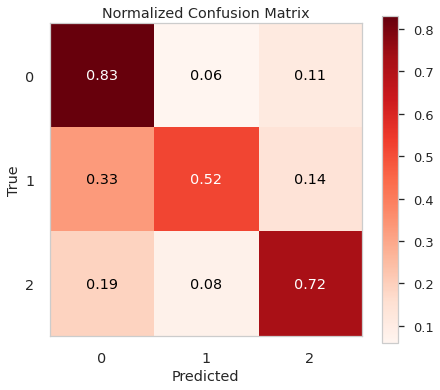

In [ ]:
skplt.metrics.plot_confusion_matrix(test_labels, predicted_labels, 
                                    cmap = 'Reds', normalize=True, 
                                    text_fontsize='large', figsize=(7, 6))

plt.ylabel("True")
plt.xlabel("Predicted")
plt.show() 